## Super resolution

In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
from torchvision.models import vgg16_bn

from google.colab import drive

import shutil

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# upload note: turn bs back to 32

In [0]:
zip_path = Path("/content/pet-colorizer.zip")
if not zip_path.exists():
  !cp "/content/gdrive/My Drive/DL/colorizer/pet-colorizer.zip" "/content/pet-colorizer.zip"
  !unzip /content/pet-colorizer.zip > /dev/null
  !ls

In [0]:
# path = Path('/home/ahmad/.fastai/data/pet-colorizer')
path = Path('/content/pet-colorizer')
path_rgb = path/'images'
path_gray = path/'gray'

In [0]:
il = ImageList.from_folder(path_rgb)

In [0]:
def crappify(fn, i, path):
    dest = path/fn.relative_to(path_rgb)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn).convert('RGB')
    pixels = img.load()
    
    for x in range(img.size[0]):
        for y in range(img.size[1]):
            r,g,b = pixels[x,y]
            # the ITU-R 601-2 luma transform:
            pixels[x,y] = tuple([int(0.2989 * r + 0.5870 * g + 0.1140 * b)] * 3)
    
    img.save(dest)

In [0]:
# img = PIL.Image.open(path_lr/'Abyssinian_1.jpg')
# px = img.load()
# px[0,0]
# crappify(Path('/home/ahmad/.fastai/data/pet-colorizer/images_test/Abyssinian_1.jpg'), 0, path_lr, size)

In [0]:
# create smaller image sets the first time this nb is run
if not path_gray.exists(): 
    for fn in il.items:
        crappify(fn, 0, path_gray)
#     parallel(partial(crappify, path=path_gray), il.items)

In [0]:
bs,size=32,128
# bs, size = 4, 128
arch = models.resnet34

src = ImageImageList.from_folder(path_gray).split_by_rand_pct(0.1, seed=42)

In [0]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_rgb/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
data = get_data(bs,size)

In [0]:
# data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Feature loss

In [0]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [0]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [0]:
base_loss = F.l1_loss

In [0]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [0]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [0]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[1:5], [2,5,15,2])

## Train

In [0]:
learn = None
gc.collect()

wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)

In [0]:
# learn.lr_find()
# learn.recorder.plot()

In [0]:
lr = 8e-5

In [0]:
def save_model(learn, save_name):
  learn.save(save_name)
  save_path = '/content/' + save_name
  learn.save(save_path)
  shutil.copyfile(save_path + '.pth', '/content/gdrive/My Drive/DL/colorizer/models/' + save_name + '.pth')  

def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    save_model(learn, save_name)
    learn.show_results(rows=5, imgsize=5)

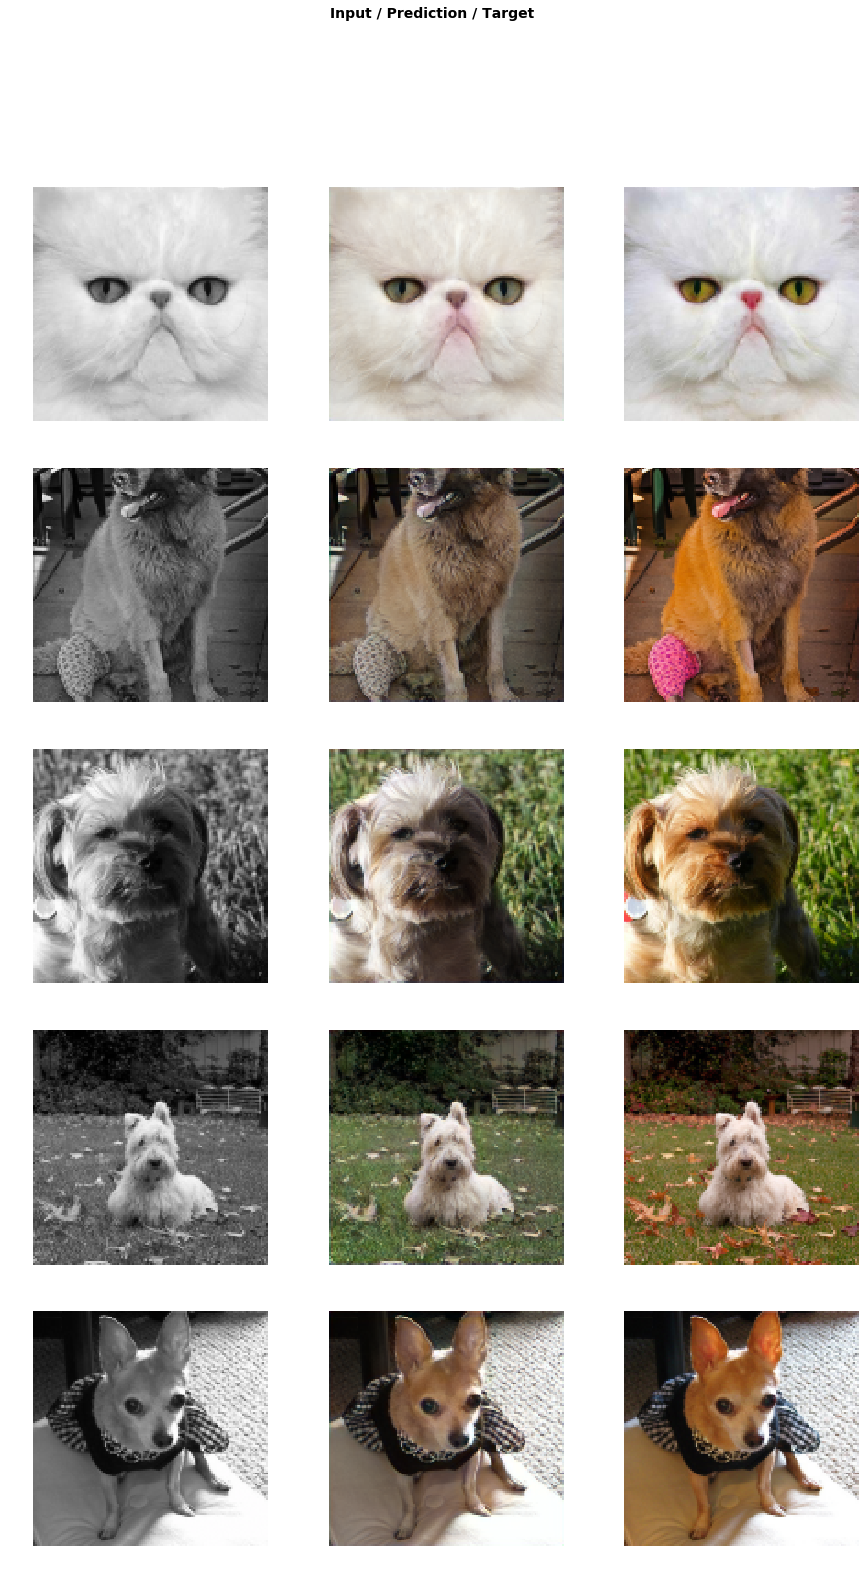

In [0]:
do_fit('1a', slice(lr*10))

In [0]:
learn.unfreeze()

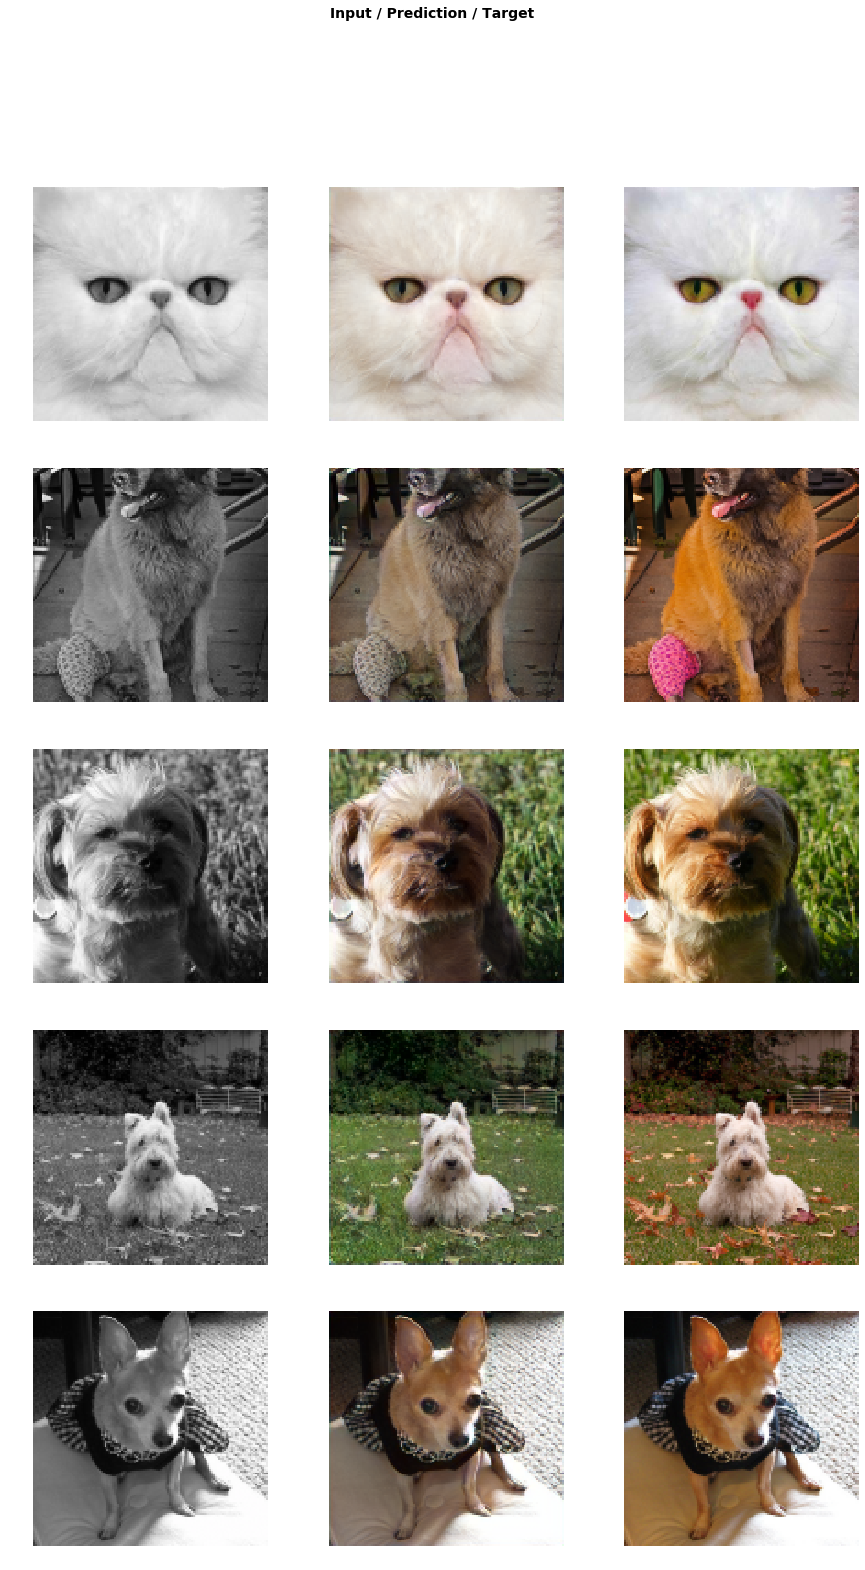

In [0]:
do_fit('1b', slice(8e-6,lr))

In [0]:
data = get_data(12,size*2)

In [0]:
learn.data = data
learn.freeze()
gc.collect()

29168

In [0]:
learn.load('1b');

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


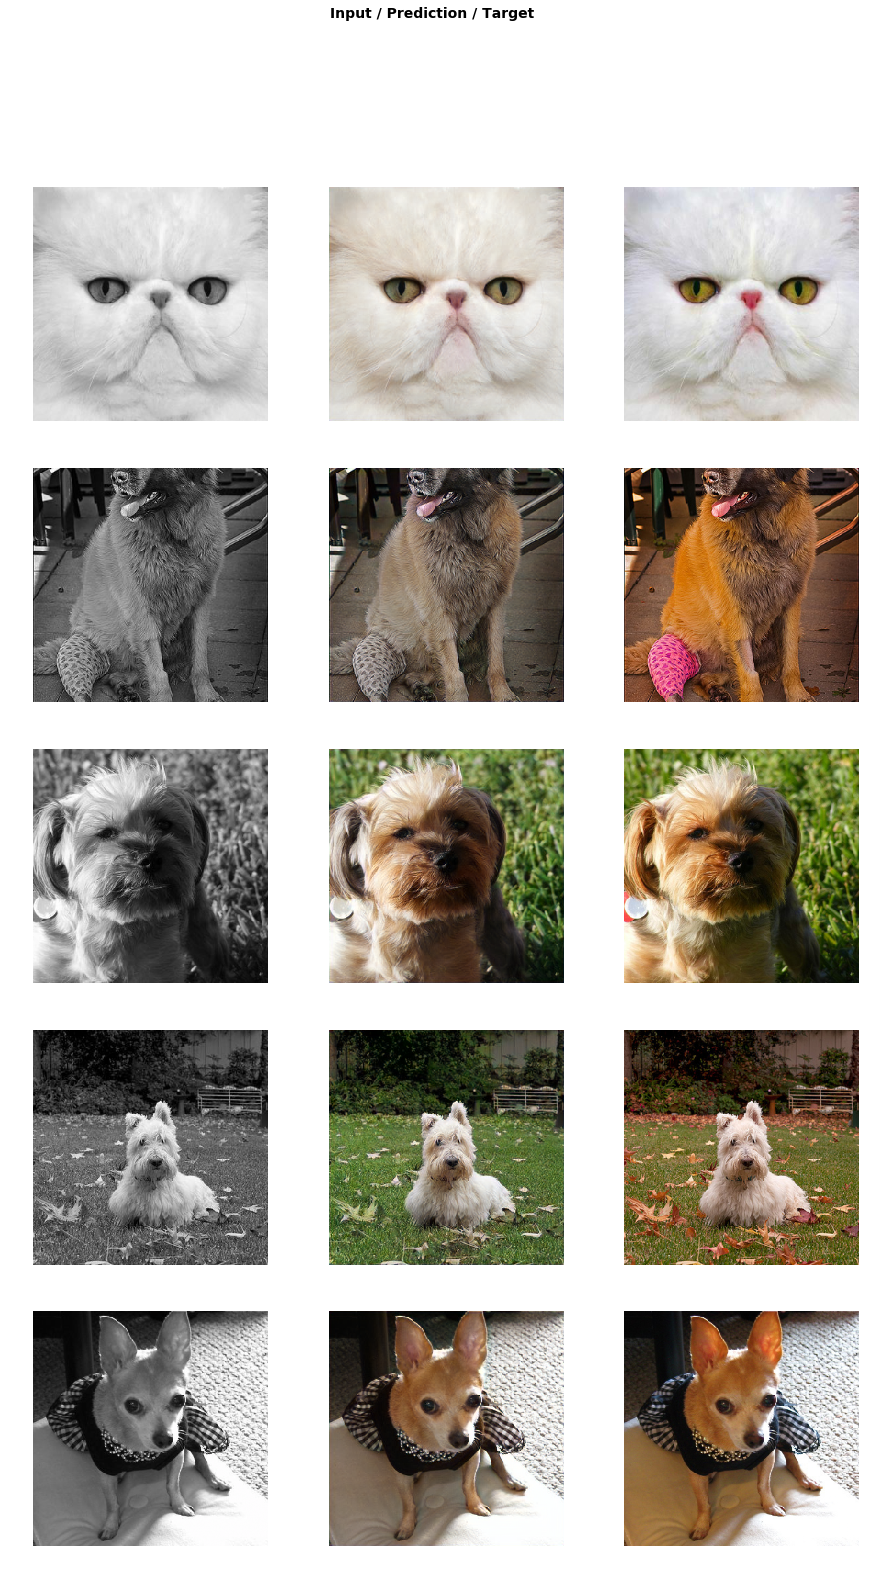

In [0]:
do_fit('2a')

In [0]:
learn.unfreeze()

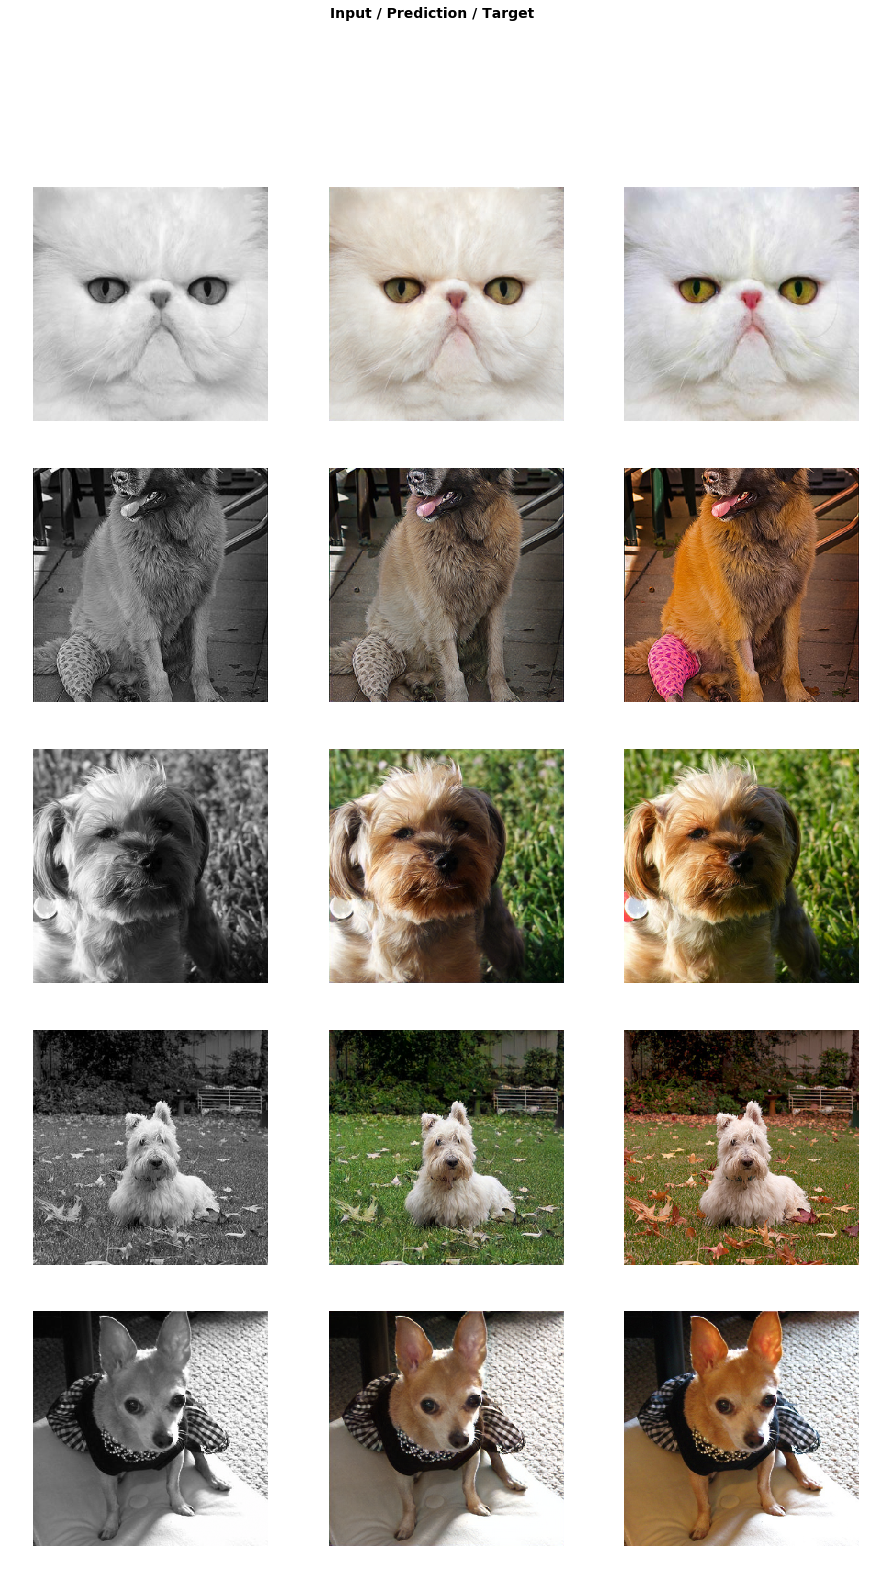

In [0]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

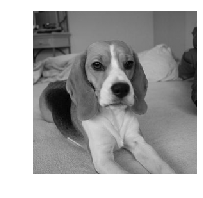

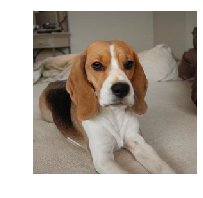

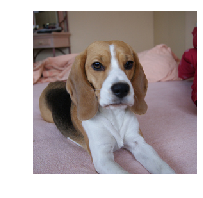

In [0]:
index = 120

item = learn.data.valid_ds[index][0]
label = learn.data.valid_ds[index][1]
pred = learn.predict(item)[0]

item.show()
pred.show()
label.show()
# Image(learn.predict().show()
# item

## Test

In [0]:
learn = None
gc.collect();

In [0]:
256/320*1024

819.2

In [0]:
256/320*1600

1280.0

In [0]:
free = gpu_mem_get_free_no_cache()
# the max size of the test image depends on the available GPU RAM 
if free > 8000: size=(1280, 1600) # >  8GB RAM
else:           size=( 820, 1024) # <= 8GB RAM
print(f"using size={size}, have {free}MB of GPU RAM free")

using size=(1280, 1600), have 14201MB of GPU RAM free


In [0]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [0]:
data_mr = (ImageImageList.from_folder(path_gray).random_split_by_pct(0.1, seed=42)
          .label_from_func(lambda x: path_rgb/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

NameError: ignored

In [0]:
learn.load('2b');

In [0]:
learn.data = data_mr

In [0]:
fn = data_mr.valid_ds.x.items[0]; fn

In [0]:
img = open_image(fn); img.shape

In [0]:
p,img_hr,b = learn.predict(img)

In [0]:
show_image(img, figsize=(18,15), interpolation='nearest');

In [0]:
Image(img_hr).show(figsize=(18,15))